In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
from sklearn.utils import check_random_state
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.ensemble import VotingClassifier
from scipy.stats.stats import pearsonr
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import ExtraTreesRegressor as ETR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import ExtraTreesClassifier as ETC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.neighbors import KNeighborsClassifier as KNNC



In [2]:
#QUESTION1

fraction_of_reds: 0.374000


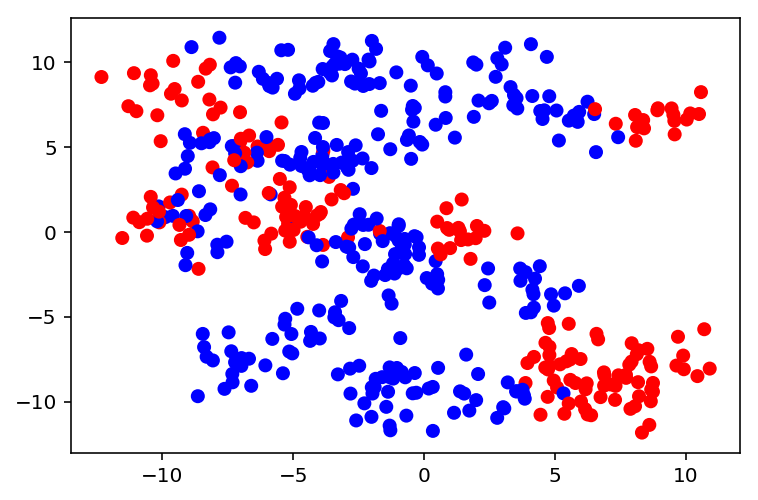

In [4]:
#Make and plot data
X,y=make_blobs(n_samples=500, centers=30, random_state=12)
labels=["r","b"]
y=np.take(labels, (y>10))
plt.scatter(X[:,0], X[:,1], color=y)

# Extract the fraction of reds
nreds=np.sum(y=='r')
nblues=np.sum(y=='b')
fraction_of_reds=float(nreds)/(nreds+nblues)
print("fraction_of_reds: %f" %fraction_of_reds)

In [5]:
#Using bagging
print( """This is a bit complicated because what I want is to fit trees on different datasets and then combine the already 
fitted trees and make them vote on each of the test points. However, the VotingClassifier wants to fit all the trees on the 
SAME dataset. I don't see other ways to do this that don't involve stackoverflow copy-pasting so I'll try to do my own
voting classifier and see if it works ¯\_(ツ)_/¯. This works for classification. For the regression case, 
I would just calculate the mean""")

ntrees=501
max_depth=100
trees_bootstrap=[]
tree_train_scores_bootstrap=[]
tree_test_scores_bootstrap=[]
predictions=[]

X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.5, random_state=0)
for i in range(ntrees):
    bootsample=resample(X_train,y_train)
    clf=DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(bootsample[0], bootsample[1])
    tree_train_scores_bootstrap.append(clf.score(bootsample[0], bootsample[1]))
    tree_test_scores_bootstrap.append(clf.score(X_test, y_test))
    trees_bootstrap.append(('tree', clf))
    predictions.append(clf.predict(X_test))

finalvote=[]
for j in range(len(X_test)):
    votes=[]
    for k in range(len(predictions)):
        votes.append(predictions[k][j])
    votes=np.array(votes)
    reds=np.sum(votes=='r')
    proportion=float(reds)/len(votes)
    if proportion>0.5:
        finalvote.append('r')
    elif proportion<0.5:
        finalvote.append('b')
    else:
        finalvote.append(np.nan)
            

This is a bit complicated because what I want is to fit trees on different datasets and then combine the already 
fitted trees and make them vote on each of the test points. However, the VotingClassifier wants to fit all the trees on the 
SAME dataset. I don't see other ways to do this that don't involve stackoverflow copy-pasting so I'll try to do my own
voting classifier and see if it works ¯\_(ツ)_/¯. This works for classification. For the regression case, 
I would just calculate the mean


In [8]:
print("RESULTS FOR BAGGING")
forest_test_score=accuracy_score(finalvote, y_test)
mean_tree_test_score=np.mean(tree_test_scores_bootstrap)

#correlation coefficient between tree0 and tree1
y0=predictions[0]
y1=predictions[1]

y0[y0=='r']=0
y0[y0=='b']=1
y0=y0.astype(int)
y1[y1=='r']=0
y1[y1=='b']=1
y1=y1.astype(int)
corr01=pearsonr(y0,y1)

print("Average test score of individual trees: %f" % mean_tree_test_score)
print ("Forest test score: %f" % forest_test_score)
print ("correlation between tree0 and tree1: %f" % corr01[0])

print("We get a better score using the bagging technique. Our trees are quite correlated because we use a relatively large training set so the samples are similar to each other")

RESULTS FOR BAGGING
Average test score of individual trees: 0.827465
Forest test score: 0.856000
correlation between tree0 and tree1: 0.684343
We get a better score using the bagging technique. Our trees are quite correlated because we use a relatively large training set so the samples are similar to each other


In [12]:
# Using a subset of features each time
ntrees=500
params_subset=1
max_depth=5
trees=[]
tree_train_scores=[]
tree_test_scores=[]
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.5, random_state=0)
for i in range(ntrees):
    #params=random.sample(labels,1)[0]
    clf=DecisionTreeClassifier(criterion='gini', max_features=params_subset, max_depth=max_depth, random_state=None)
    #trees.append(('tree',clf.fit(X_train,y_train)))
    clf.fit(X_train, y_train)
    trees.append(('tree'+str(i), clf))
    tree_train_scores.append(clf.score(X_train, y_train))
    tree_test_scores.append(clf.score(X_test, y_test))

voting=VotingClassifier(trees)
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('tree0', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
         ...it=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [14]:
print("RESULTS FOR RANDOM FOREST")
forest_train_score=voting.score(X_train,y_train)
forest_test_score=voting.score(X_test,y_test)

avg_tree_train_score=np.mean(tree_train_scores)
avg_tree_test_score=np.mean(tree_test_scores)

print("Average score of individual trees: Train=%f, Test=%f" %(avg_tree_train_score, avg_tree_test_score))
print("Forest score: Train=%f, Test=%f" %(forest_train_score, forest_test_score))

#correlation coefficient between tree0 and tree1
tree0=trees[0][1]
tree1=trees[1][1]
tree0.fit(X_test, y_test)
tree1.fit(X_test, y_test)
y0=tree0.predict(X_test)
y0[y0=='r']=0
y0[y0=='b']=1
y0=y0.astype(int)
y1=tree1.predict(X_test)
y1[y1=='r']=0
y1[y1=='b']=1
y1=y1.astype(int)
corr01=pearsonr(y0,y1)
print("correlation between tree0 and tree1: %f" % corr01[0])

print("we get a better test score with the random forest. The trees remain highly correlated (between trees 0 and 1: %f) but it's still good enough to improve our prediction. If we set the random_state argument in the DecisionTreeClassifier to any value (0 for example), we get the same tree everytime and we can see that the average individual tree and random forest scores are the same. We can anyway expect that with data with only 2 predictors, the trees will be highly correlated as there are less parameters to randomly sample at each node of the trees." %corr01[0])

RESULTS FOR RANDOM FOREST
Average score of individual trees: Train=0.896552, Test=0.803104
Forest score: Train=0.928000, Test=0.840000
correlation between tree0 and tree1: 0.624760
we get a better test score with the random forest. The trees remain highly correlated (between trees 0 and 1: 0.624760) but it's still good enough to improve our prediction. If we set the random_state argument in the DecisionTreeClassifier to any value (0 for example), we get the same tree everytime and we can see that the average individual tree and random forest scores are the same. We can anyway expect that with data with only 2 predictors, the trees will be highly correlated as there are less parameters to randomly sample at each node of the trees.


C:\Users\BigusDickus\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\BigusDickus\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [8]:
#Question2

In [15]:

data=pd.read_csv("C:\\Users\\BigusDickus\\Desktop\\ACT\\bank-additional-full.csv", sep=';')

In [16]:
var_names=data.columns.tolist()
categ=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome','y']
quantit=[i for i in var_names if i not in categ]

job=pd.get_dummies(data['job'])
marital = pd.get_dummies(data['marital'])
education = pd.get_dummies(data['education'])
default = pd.get_dummies(data['default'])
housing = pd.get_dummies(data['housing'])
loan = pd.get_dummies(data['loan'])
contact = pd.get_dummies(data['contact'])
month = pd.get_dummies(data['month'])
day = pd.get_dummies(data['day_of_week'])
poutcome = pd.get_dummies(data['poutcome'])

dict_map=dict()
y_map={'yes':1, 'no': 0}
dict_map['y']=y_map
data=data.replace(dict_map)
label=data['y']

df1 = data[quantit]
df1_names = df1.keys().tolist()


df1 = pd.DataFrame(df1)
df1.columns = df1_names

banking = pd.concat([df1,
                      job,
                      marital,
                      education,
                      default,
                      housing,
                      loan,
                      contact,
                      month,
                      day,
                      poutcome,
                      label], axis=1)

banking.to_csv('bank_cleaned.csv', index = False)


In [17]:
X_train, X_test, y_train, y_test=train_test_split(banking.iloc[:,0:-1],banking.iloc[:,-1], train_size=0.8 )
print("We use a test set despite using cross-validation because what we are essentially doing with GridSearchCV is use k-1 folds of the training set to fit the model parameters to the data, for each set of hyperparameters that we are gridsearching on. We then use the last fold to estimate the accuracy of the model, with a particular set of hyperparameters. This means that the cross-validation score is not an unbiased estimate because we precisely choosew the set of hyperparameters that maximise the cross-validation score. Therefore, to estimate our model accuracy in an unbiased way, we test the model (with fixed model parameters and hyperparameters) on a set of previously unused data")

We use a test set despite using cross-validation because what we are essentially doing with GridSearchCV is use k-1 folds of the training set to fit the model parameters to the data, for each set of hyperparameters that we are gridsearching on. We then use the last fold to estimate the accuracy of the model, with a particular set of hyperparameters. This means that the cross-validation score is not an unbiased estimate because we precisely choosew the set of hyperparameters that maximise the cross-validation score. Therefore, to estimate our model accuracy in an unbiased way, we test the model (with fixed model parameters and hyperparameters) on a set of previously unused data


C:\Users\BigusDickus\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [19]:
train_scores=[]
test_scores=[]
depths=np.arange(1,20)
for i in depths:
    clf=DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train, y_train)
    train_score=clf.score(X_train, y_train)
    test_score=clf.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)

In [21]:
print(opt_length)

6


This is just a quick test by hand to see roughly where we can expect to see the best tree depth. We get a best tree length of 6


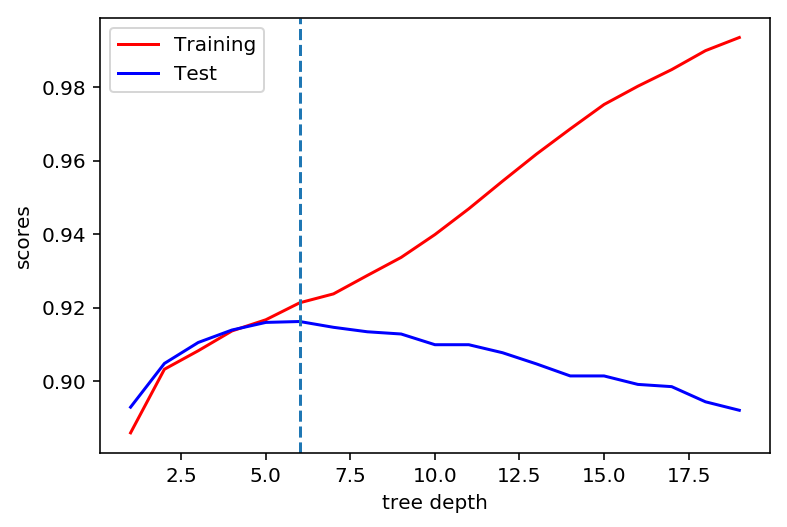

In [24]:
trains,=plt.plot(depths, train_scores, color='r')
tests,=plt.plot(depths, test_scores, color='b')
plt.xlabel('tree depth')
plt.ylabel('scores')
plt.legend([trains, tests],['Training', 'Test'])
opt_length=np.argmax(test_scores)+1
plt.axvline(opt_length, linestyle='--')

print("This is just a quick test by hand to see roughly where we can expect to see the best tree depth. We get a best tree length of %i" %opt_length)

In [25]:

print("Because this gridsearch takes 3mn to execute (on my laptop), I don't run it again. I just copied the optimal parameters in the next cell. I had already run a quick gridsearch on the n_estimators and got an optimum at n=200")
# param_grid={
#     'max_depth': np.arange(1,26,5)
# }
# clf=GridSearchCV(RFC(n_estimators=200), param_grid=param_grid, cv=5, verbose=3)
# clf.fit(X_train, y_train)
# clf.best_params_
# train=clf.score(X_train, y_train)
# test=clf.score(X_test, y_test)

Because this gridsearch takes 3mn to execute (on my laptop), I don't run it again. I just copied the optimal parameters in the next cell. I had already run a quick gridsearch on the n_estimators and got an optimum at n=200


In [26]:
best_score=0.91286798179059181
bestdepth=16
trainscore=0.973899848255
testscore=0.914906530711
print("Best cross-validation score for 200 trees: %f" % best_score)
print("Tree depth: %i" % bestdepth)
print("Training score: %f" %trainscore)
print("Test score on the untouched test set: %f" % testscore)


Best cross-validation score for 200 trees: 0.912868
Tree depth: 16
Training score: 0.973900
Test score on the untouched test set: 0.914907


In [16]:
print("QUESTION3")
print("In the following, for each model, I perform a gridsearhcv to find optimal parameters. Because the gridsearch takes a while to execute, I ran them only once and copied down the optimal parameters I found and plugged them into the regressors")

QUESTION3
In the following, for each model, I perform a gridsearhcv to find optimal parameters. Because the gridsearch takes a while to execute, I ran them only once and copied down the optimal parameters I found and plugged them into the regressors


In [27]:
cal_housing=fetch_california_housing()
X=cal_housing.data
y=cal_housing.target
X_train, X_test, y_train, y_test=train_test_split(X,y, train_size=0.7)

C:\Users\BigusDickus\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [28]:
print("I do not run this code again because it takes ages")
# param_grid={
#     'max_depth': np.arange(2,22,2),
#     'n_estimators': np.arange(50,300,50),
#     'max_features': np.arange(1,len(cal_housing.feature_names))
# }
# RFclf=GridSearchCV(RFR(), param_grid=param_grid, cv=5, verbose=3)
# RFclf.fit(X_train, y_train)
# RFclf.best_params_
# RFgstrain=RFclf.score(X_train, y_train)
# RFgstest=RFclf.score(X_test, y_test)

I do not run this code again because it takes ages


In [29]:
RFmaxdepth=20
RFnestimators=200
RFmaxfeatures=3

print("""
RANDOM FORESTS GRID SEARCH RESULTS
We find the best parameters to be:
max_depth: 20
n_estimators: 200
max_features: 3
""")


RANDOM FORESTS GRID SEARCH RESULTS
We find the best parameters to be:
max_depth: 20
n_estimators: 200
max_features: 3



In [37]:
RFrgr=RFR(max_depth=RFmaxdepth,n_estimators=RFnestimators, max_features=RFmaxfeatures)
RFrgr.fit(X_train, y_train)
RFrgrtrain=RFrgr.score(X_train, y_train)
RFrgrtest=RFrgr.score(X_test, y_test)
RFimportances=RFrgr.feature_importances_

In [38]:
print("RANDOM FOREST TRAINING/TEST SCORES")
print("Training score: %f" %RFrgrtrain)
print("Test score on the untouched test set: %f" % RFrgrtest)


RANDOM FOREST TRAINING/TEST SCORES
Training score: 0.972826
Test score on the untouched test set: 0.828106


In [39]:
print("I do not run the gridsearch again because it takes a while")

# param_grid={
#     'max_features': np.arange(1,len(cal_housing.feature_names)-1),
# }
# ETgs=GridSearchCV(ETR(n_estimators=RFnestimators, max_depth=RFmaxdepth), param_grid=param_grid, verbose=3, cv=5)
# ETgs.fit(X_train, y_train)
# ETgstrainscore=ETgs.score(X_train, y_train)
# ETgstestscore=ETgs.score(X_test,y_test)


I do not run the gridsearch again because it takes a while


In [40]:
ETmaxfeatures=5

print("""
EXTRA TREES GRID SEARCH RESULTS
Best max_features: 5
""")


EXTRA TREES GRID SEARCH RESULTS
Best max_features: 5



In [41]:
ETrgr=ETR(n_estimators=RFnestimators, max_depth=RFmaxdepth, max_features=ETmaxfeatures)
ETrgr.fit(X_train, y_train)
ETrgrtrainscore=ETrgr.score(X_train, y_train)
ETrgrtestscore=ETrgr.score(X_test,y_test)
ETimportances=ETrgr.feature_importances_

In [42]:
print("EXTRA TREES TRAINING/TEST SCORES")
print("Training score: %f" %ETrgrtrainscore)
print("Test score on the untouched test set: %f" % ETrgrtestscore)

EXTRA TREES TRAINING/TEST SCORES
Training score: 0.977863
Test score on the untouched test set: 0.823737


In [43]:
print("I do not run the gridsearch again because it takes a while")

# param_grid={
#     'learning_rate': np.arange(0.05, 0.2, 0.05)
# }
# GBgs=GridSearchCV(GBR(n_estimators=RFnestimators), param_grid=param_grid, verbose=3, cv=5)
# GBgs.fit(X_train, y_train)
# #GBimportances=GB.feature_importances_

I do not run the gridsearch again because it takes a while


In [44]:
GBlearningrate=0.2
print("""
GRADIENT BOOSTING GRID SEARCH RESULTS
Best learning_Rate: 0.2
""")


GRADIENT BOOSTING GRID SEARCH RESULTS
Best learning_Rate: 0.2



In [45]:
GBrgr=GBR(n_estimators=RFnestimators, learning_rate=GBlearningrate)
GBrgr.fit(X_train, y_train)
GBrgrtrainscore=GBrgr.score(X_train, y_train)
GBrgrtestscore=GBrgr.score(X_test,y_test)
GBimportances=GBrgr.feature_importances_

In [46]:
print("GRADIENT BOOSTING TRAIN/TEST SCORES")
print("Training score: %f" %GBrgrtrainscore)
print("Test score on the untouched test set: %f" % GBrgrtestscore)

GRADIENT BOOSTING TRAIN/TEST SCORES
Training score: 0.863607
Test score on the untouched test set: 0.829737


Text(0,0.5,'Feature importances')

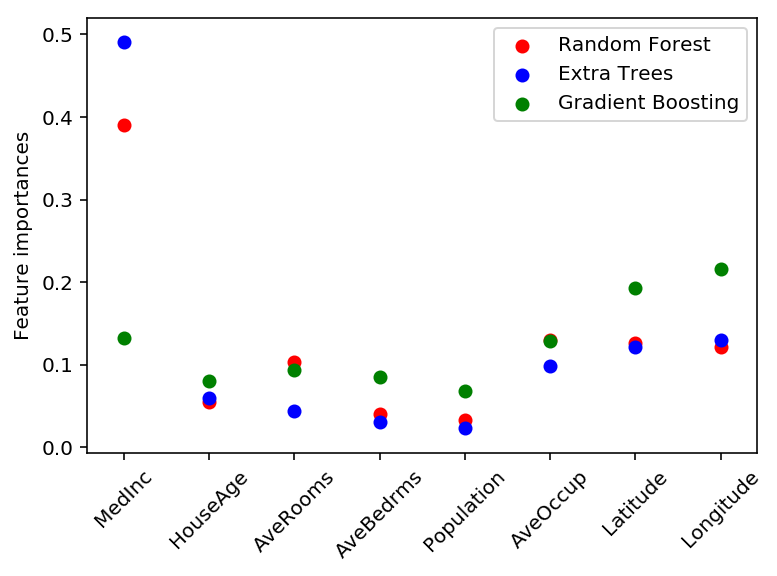

In [47]:
randomforest=plt.scatter(np.arange(8),RFimportances, color='r')
extratrees=plt.scatter(np.arange(8),ETimportances, color='b')
gradientboost=plt.scatter(np.arange(8),GBimportances, color='g')
plt.xticks(np.arange(8),cal_housing.feature_names, rotation=45)
plt.legend([randomforest, extratrees, gradientboost],['Random Forest', 'Extra Trees', 'Gradient Boosting'])
plt.ylabel('Feature importances')

In [48]:
print("The different models have similar test scores. Random forest and extra trees predictions are similar in predicting a highest impact of the average income on the house prices. Location seems to be important as well.")

The different models have similar test scores. Random forest and extra trees predictions are similar in predicting a highest impact of the average income on the house prices. Location seems to be important as well.


In [49]:
print("We try to get the mean predictions of the models to see if/how much we can improve on it")
RFpredict=RFrgr.predict(X_test)
ETpredict=ETrgr.predict(X_test)
GBpredict=GBrgr.predict(X_test)

meanmodelpredicts=[]
for j in range(len(X_test)):
    predicts=(RFpredict[j], ETpredict[j], GBpredict[j])
    meanmodelpredicts.append(np.mean(predicts))


We try to get the mean predictions of the models to see if/how much we can improve on it


In [50]:
meanmodel_score=r2_score(y_test, meanmodelpredicts)
RFscore=r2_score(y_test, RFpredict)
ETscore=r2_score(y_test, ETpredict)
GBscore=r2_score(y_test, GBpredict)
print("Random Forest score= %f" %RFscore)
print("Extra trees score= %f" %ETscore)
print("Gradient boosting score= %f" %GBscore)
print("Mean prediction score= %f" %meanmodel_score)
print("We indeed get a small improvement in our prediction scores. Yay!")

Random Forest score= 0.828106
Extra trees score= 0.823737
Gradient boosting score= 0.829737
Mean prediction score= 0.837172
We indeed get a small improvement in our prediction scores. Yay!


In [51]:
print("QUESTION4")
df_train=pd.read_csv("C:\\Users\\BigusDickus\\Desktop\\ACT\\couille.csv", header=None, sep=',')

QUESTION4


In [136]:
X=df_train.as_matrix()[:,:-1]
y=df_train.as_matrix()[:,-1]
X2=np.copy(X)
X2=np.delete(X2,46, 1)

In [53]:
X_train, X_test, y_train, y_test=train_test_split(X2,y, train_size=0.85, random_state=0)
folds=5
print("I tried to optimise and combine different models but I got a better result if I only ued gradient boosting so I stuck with that")

I tried to optimise and combine different models but I got a better result if I only ued gradient boosting so I stuck with that


C:\Users\BigusDickus\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [54]:
# print "ESTIMATE OPTIMAL K FOR KNN"
# param_grid={
#     'n_neighbors': np.arange(10, 1501, 50)
#     #'n_neighbors': np.arange(1,2,1)
#  }
# KNNgs=GridSearchCV(KNNC(algorithm='ball_tree'), param_grid=param_grid, cv=5, verbose=3)
# KNNgs.fit(X_train, y_train)
# KNNgs.best_params_
# KNNgstrain=KNNgs.score(X_train, y_train)
# KNNgstest=KNNgs.score(X_test, y_test)

In [55]:
# "OPTIMAL NEIGHBOURS"
#previousopti=150
#nneighbors=KNNgs.best_params_['n_neighbors']
#nneighbors=110
#print nneighbors

In [56]:
#KNNclf=KNNC(n_neighbors=110)
#KNNclf=KNNC(nneighbors)

#KNNclf.fit(X_train, y_train)
#KNNtrainscore=KNNclf.score(X_train, y_train)
#KNNtestscore=KNNclf.score(X_test, y_test)


In [57]:
#print "RESULTS FOR KNN"
#print KNNtrainscore
#print KNNtestscore

In [58]:
# print "ESTIMATE OPTIMAL PARAMS FOR RANDOM FOREST"
# param_grid={
#     'n_estimators': np.arange(100,401,100),
#     'max_depth': np.arange(3,34,3),
#     'bootstrap': (True,False),
# #    #'n_estimators': np.arange(1,2),
# #    #'max_depth': np.arange(1,2),
# #    #'bootstrap': (True,False),
#  }
# RFgs=GridSearchCV(RFC(), param_grid=param_grid, cv=5, verbose=3)
# RFgs.fit(X_train, y_train)
# RFgs.best_params_
# RFgstrain=RFgs.score(X_train, y_train)
# RFgstest=RFgs.score(X_test, y_test)

In [59]:
#print "OPTIMAL PARAMS FOR RF"
# nestimators=RFgs.best_params_['n_estimators']
# maxdepth=RFgs.best_params_['max_depth']
# bootstrap=RFgs.best_params_['bootstrap']
#nestimators=400
#maxdepth=21
#bootstrap=False
# print nestimators, maxdepth, bootstrap


In [60]:
#RFclf=RFC(n_estimators=200, max_depth=6, bootstrap=False)
#RFclf=RFC(n_estimators=nestimators, max_depth=maxdepth, bootstrap=bootstrap)

#RFclf.fit(X_train, y_train)
#RFtrainscore=RFclf.score(X_train, y_train)
#RFtestscore=RFclf.score(X_test, y_test)
#RFimportances=RFclf.feature_importances_

In [61]:
#print "RESULTS FOR RANDOM FOREST"
#print RFtrainscore
#print RFtestscore
#print RFclf.feature_importances_

In [62]:
# print "ESTIMATE OPTIMAL PARAMS FOR EXTRATREES"
# param_grid={
#     'n_estimators': np.arange(100,401,100),
#     'max_depth': np.arange(3,34,3),
#     'bootstrap': (True,False),
#     #'n_estimators': np.arange(1,2),
#     #'max_depth': np.arange(1,2),
#     #'bootstrap': (True,False),
#  }
# ETgs=GridSearchCV(ETC(), param_grid=param_grid, cv=5, verbose=3)
# ETgs.fit(X_train, y_train)
# ETgs.best_params_
# ETgstrain=RFgs.score(X_train, y_train)
# ETgstest=RFgs.score(X_test, y_test)

In [63]:
#print "OPTIMAL PARAMS FOR ET"
# nestimators=ETgs.best_params_['n_estimators']
# maxdepth=ETgs.best_params_['max_depth']
# bootstrap=ETgs.best_params_['bootstrap']
#nestimators=300
#maxdepth=30
#bootstrap=False
#print nestimators, maxdepth, bootstrap

In [64]:
#ETclf=RFC(n_estimators=200, max_depth=6, bootstrap=False)
#ETclf=ETC(n_estimators=nestimators, max_depth=maxdepth, bootstrap=bootstrap)

#ETclf.fit(X_train, y_train)
#ETtrainscore=ETclf.score(X_train, y_train)
#ETtestscore=ETclf.score(X_test, y_test)
#ETimportances=ETclf.feature_importances_

In [65]:
#print "RESULTS FOR EXTRA TREES"
#print ETtrainscore
#print ETtestscore
#print ETclf.feature_importances_

In [66]:
# print "ESTIMATE OPTIMAL LEARNING RATE FOR GB"
# param_grid={
#     'learning_rate': np.arange(0.05, 0.2, 0.05)
#     #'learning_rate': np.arange(0.1,0.2, 0.1)
# }
# GBgs=GridSearchCV(GBR(n_estimators=nestimators), param_grid=param_grid, verbose=3, cv=5)
# GBgs.fit(X_train, y_train)
# GBgs.best_params_
# GBgstrain=GBgs.score(X_train, y_train)
# GBgstest=GBgs.score(X_test, y_test)

In [67]:
# print "OPTIMAL LEARNING RATE FOR GB"
# #learningrate=GBgs.best_params_['learning_rate']
# learningrate=0.2
# print learningrate

In [68]:
# #GBclf=GBC(learning_rate=0.15)
# GBclf=GBC(learning_rate=learningrate)

# GBclf.fit(X_train, y_train)
# GBtrainscore=GBclf.score(X_train, y_train)
# GBtestscore=GBclf.score(X_test, y_test)
# GBimportances=GBclf.feature_importances_

In [69]:
# print "RESULTS FOR GB"
# print GBtrainscore
# print GBtestscore
# print GBclf.feature_importances_

In [70]:
# print "We test combined models"
# from sklearn.ensemble import VotingClassifier as VC

# combinedmodel=VC(estimators=[('knn',KNNclf), ('randomforest',RFclf),('extratree',ETclf), ('gradientboosting',GBclf)], voting='soft')

In [71]:
# combinedmodel.fit(X_train, y_train)
# combinedmodel.score(X_test, y_test)

In [72]:
# combinedmodel2=VC(estimators=[('knn',KNNC(nneighbors)), ('randomforest',RFC(n_estimators=nestimators, max_depth=maxdepth, bootstrap=bootstrap)),('extratree',ETC(n_estimators=nestimators, max_depth=maxdepth, bootstrap=bootstrap)), ('gradientboosting',GBC(learning_rate=learningrate))], voting='soft')
# combinedmodel2.fit(X_train, y_train)
# combinedmodel2.score(X_test, y_test)


In [73]:
# combinedmodel3=VC(estimators=[('randomforest',RFC(n_estimators=nestimators, max_depth=maxdepth, bootstrap=bootstrap)),('extratree',ETC(n_estimators=nestimators, max_depth=maxdepth, bootstrap=bootstrap)), ('gradientboosting',GBC(learning_rate=learningrate))], voting='hard')
# combinedmodel3.fit(X_train, y_train)
# combinedmodel3.score(X_test, y_test)

In [74]:
# cm3_predicts=combinedmodel3.predict(X_test)
# cm3_recall=recall_score(y_test, cm3_predicts)
# cm3_precision=precision_score(y_test, cm3_predicts)
# cm3_accuracy=accuracy_score(y_test, cm3_predicts)
# print cm3_recall, cm3_precision, cm3_accuracy

In [75]:
# gb_predicts=GBclf.predict(X_test)
# gb_recall=recall_score(y_test, gb_predicts)
# gb_precision=precision_score(y_test, gb_predicts)
# gb_accuracy=accuracy_score(y_test, gb_predicts)
# print gb_recall, gb_precision, gb_accuracy

In [76]:
# print KNNtestscore
# print RFtestscore
# print ETtestscore
# print GBtestscore

In [77]:
# gbplot=plt.scatter(np.arange(len(GBimportances)),GBimportances, color='red')
# etplot=plt.scatter(np.arange(len(ETimportances)),ETimportances, color='blue')
# rfplot=plt.scatter(np.arange(len(RFimportances)),RFimportances, color='green')
# plt.legend([gbplot, etplot, rfplot],['GB', 'ET', 'RF'])



In [78]:
# from sklearn.metrics import confusion_matrix as cm
# import plot_confusion_matrix
# confmat3=cm(y_test, cm3_predicts)
# np.shape(confmat3)
# plot_confusion_matrix.plot_confusion_matrix(confmat3, np.arange(2))

In [79]:
#from sklearn.tree import DecisionTreeClassifier as DTC

In [80]:
# grid_params={
#     'max_depth':np.arange(1,11),
# }
# DTgs=GridSearchCV(DTC(), param_grid=grid_params, verbose=3, cv=5)
# DTgs.fit(X_train, y_train)


In [81]:
# from sklearn.tree import export_graphviz as export
# print DTgs.score(X_train, y_train)
# print DTgs.score(X_test, y_test)
# print DTgs.best_params_

In [82]:
# print np.shape(X_train), np.shape(X_test)
# print np.shape(y_train), np.shape(y_test)
# print np.sum(y==0), np.sum(y==1)
# DTclf=DTC(max_depth=DTgs.best_params_['max_depth'])
# DTclf.fit(X_train, y_train)
# print DTclf.score(X_test, y_test)


In [83]:
# #export(DTclf, 'test_alldata.DOT')
# predicts=DTclf.predict(X_test)

In [84]:
# plt.subplot(211)
# plt.scatter(X_test[:,46], predicts)
# plt.subplot(212)
# plt.scatter(X_test[:,46], y_test)


In [85]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score


In [87]:
print("After seeing previously that I got a better prediction with using just gradient boosting than with a combination of gradient boosting, random forest knn and extra trees, I decided to try and to a thorough optimisation of gradient boosting and just use that. The optimisation steps are commented because they take ages (I left the computer to run overnight) but I copied the optimal parameters and plugged them into the next step of optimisation. I essentially optimise the parameters one by one, starting with the parameters that supposedly have the greatest impact, while fixing the others to some default reasonable value")
print("Step1: tune n_estimators while keeping other parameters fixed to a default value")
# param_grid={'n_estimators': np.arange(1,401,10)}
# GBgs2=GridSearchCV(GBC(learning_rate=0.1, min_samples_split=0.4, max_depth=8, max_features='sqrt', subsample=0.8), param_grid=param_grid, cv=5, scoring='roc_auc', verbose=3)
# GBgs2.fit(X_train, y_train)
# GBgs2.best_params_
# GBgs2.score(X_test, y_test)

After seeing previously that I got a better prediction with using just gradient boosting than with a combination of gradient boosting, random forest knn and extra trees, I decided to try and to a thorough optimisation of gradient boosting and just use that. The optimisation steps are commented because they take ages (I left the computer to run overnight) but I copied the optimal parameters and plugged them into the next step of optimisation. I essentially optimise the parameters one by one, starting with the parameters that supposedly have the greatest impact, while fixing the others to some default reasonable value
Step1: tune n_estimators while keeping other parameters fixed to a default value


In [88]:
print("Step2: tune max_Depth and min:_samples_split")
# nestimators=GBgs2.best_params_['n_estimators']
# param_grid={'max_depth': np.arange(4,21,2), 'min_samples_split':np.arange(100,2101, 250)}
# GBgs3=GridSearchCV(GBC(n_estimators=nestimators,learning_rate=0.1, max_features='sqrt', subsample=0.8), param_grid=param_grid, cv=5, scoring='roc_auc', verbose=3)
# GBgs3.fit(X_train, y_train)
# GBgs3.best_params_
# GBgs3.score(X_test, y_test)

Step2: tune max_Depth and min:_samples_split


In [108]:
print("Step 2.2 Tune max samples per leaf (step 2.2 because I forgot to insert it and was too lazy to renumber the following steps)")
#param_grid={'min_samples_leaf':np.arange(20,101,15)}
#GBgs3_2=GridSearchCV(GBC(n_estimators=nestimators,learning_rate=0.1, max_depth=maxdepth, min_samples_split=minsamplessplit, subsample=0.8), param_grid=param_grid, cv=5, scoring='roc_auc', verbose=3)
#GBgs3_2.fit(X_train, y_train)
#GBgs3_2.best_params_
#GBgs3_2.score(X_test, y_test)

Step 2.2 Tune max samples per leaf (step 2.2 because I forgot to insert it and was too lazy to renumber the following steps)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] min_samples_leaf=20 .............................................


KeyboardInterrupt: 

In [93]:
print("Step3: tune max_features")
# minsamplesleaf=95
# nestimators=391
# maxdepth=10
# minsamplessplit=2100
# param_grid={'max_features':np.arange(5,46,5)}
# GBgs4=GridSearchCV(GBC(n_estimators=nestimators,learning_rate=0.1, max_depth=maxdepth, min_samples_split=minsamplessplit, subsample=0.8, min_samples_leaf=minsamplesleaf), param_grid=param_grid, cv=5, scoring='roc_auc', verbose=3)
# GBgs4.fit(X_train, y_train)
# GBgs4.best_params_
# GBgs4.score(X_test, y_test)

Step3: tune max_features
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_features=5 ..................................................
[CV] ......... max_features=5, score=0.9689761588974576, total=  15.5s
[CV] max_features=5 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.0s remaining:    0.0s


[CV] ......... max_features=5, score=0.9684643208423525, total=  15.7s
[CV] max_features=5 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.2s remaining:    0.0s


[CV] ......... max_features=5, score=0.9704755628988401, total=  16.0s
[CV] max_features=5 ..................................................
[CV] ......... max_features=5, score=0.9686130310365051, total=  16.0s
[CV] max_features=5 ..................................................
[CV] ......... max_features=5, score=0.9690858643253579, total=  15.6s
[CV] max_features=10 .................................................
[CV] ........ max_features=10, score=0.9697003883977392, total=  27.0s
[CV] max_features=10 .................................................
[CV] ......... max_features=10, score=0.969256573497137, total=  26.8s
[CV] max_features=10 .................................................
[CV] ........ max_features=10, score=0.9710897251459313, total=  26.9s
[CV] max_features=10 .................................................
[CV] ......... max_features=10, score=0.969014729473362, total=  26.7s
[CV] max_features=10 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 46.3min finished


0.9689758441040411

In [96]:
print("Step4: tune subsamples")
# maxfeatures=GBgs4.best_params_['max_features']

# param_grid={'subsample':np.arange(0.4,1.0,0.2)}
# GBgs5=GridSearchCV(GBC(n_estimators=nestimators,learning_rate=0.1, max_depth=maxdepth, min_samples_split=minsamplessplit, min_samples_leaf=minsamplesleaf, max_features=maxfeatures), param_grid=param_grid, cv=5, scoring='roc_auc', verbose=3)
# GBgs5.fit(X_train, y_train)
# GBgs5.best_params_
# GBgs5.score(X_test, y_test)

Step4: tune subsamples
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] subsample=0.4 ...................................................
[CV] .......... subsample=0.4, score=0.9689883885922566, total=  30.4s
[CV] subsample=0.4 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.7s remaining:    0.0s


[CV] .......... subsample=0.4, score=0.9681319481310421, total=  30.0s
[CV] subsample=0.4 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


[CV] .......... subsample=0.4, score=0.9700091701001474, total=  30.3s
[CV] subsample=0.4 ...................................................
[CV] .......... subsample=0.4, score=0.9683486814796975, total=  30.0s
[CV] subsample=0.4 ...................................................
[CV] .......... subsample=0.4, score=0.9690800751207194, total=  30.6s
[CV] subsample=0.6000000000000001 ....................................
[CV]  subsample=0.6000000000000001, score=0.9690996860514323, total=  47.8s
[CV] subsample=0.6000000000000001 ....................................
[CV]  subsample=0.6000000000000001, score=0.9683298665646223, total=  47.2s
[CV] subsample=0.6000000000000001 ....................................
[CV]  subsample=0.6000000000000001, score=0.9702550665671696, total=  46.7s
[CV] subsample=0.6000000000000001 ....................................
[CV]  subsample=0.6000000000000001, score=0.9691166918400581, total=  46.7s
[CV] subsample=0.6000000000000001 .......................

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 11.9min finished


0.9696809343140573

In [122]:
print("Step5: tune learning rate")
# subsamples=0.8
# param_grid={'learning_rate': np.arange(0.05,0.2, 0.05)}
# GBgs6=GridSearchCV(GBC(n_estimators=nestimators,max_depth=maxdepth, min_samples_split=minsamplessplit, min_samples_leaf=minsamplesleaf, max_features=maxfeatures, subsample=subsamples), param_grid=param_grid, cv=3, scoring='roc_auc', verbose=3)
# GBgs6.fit(X_train, y_train)
# GBgs6.best_params_
# GBgs6.score(X_test, y_test)

Step5: tune learning rate
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate=0.05 ..............................................
[CV] ..... learning_rate=0.05, score=0.9690454629964427, total=  48.1s
[CV] learning_rate=0.05 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.5s remaining:    0.0s


[CV] ..... learning_rate=0.05, score=0.9697828461039123, total=  49.4s
[CV] learning_rate=0.05 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] ..... learning_rate=0.05, score=0.9688070906562491, total=  48.9s
[CV] learning_rate=0.1 ...............................................
[CV] ...... learning_rate=0.1, score=0.9693911034390104, total=  48.7s
[CV] learning_rate=0.1 ...............................................
[CV] ...... learning_rate=0.1, score=0.9696005595574332, total=  48.5s
[CV] learning_rate=0.1 ...............................................
[CV] ...... learning_rate=0.1, score=0.9690321312167031, total=  48.8s
[CV] learning_rate=0.15000000000000002 ...............................
[CV]  learning_rate=0.15000000000000002, score=0.9687801247004036, total=  48.9s
[CV] learning_rate=0.15000000000000002 ...............................
[CV]  learning_rate=0.15000000000000002, score=0.9689144253892724, total=  49.1s
[CV] learning_rate=0.15000000000000002 ...............................
[CV]  learning_rate=0.15000000000000002, score=0.9684574270784686, total=  48.6s
[CV] learning_rate=0.2 ........................

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  9.9min finished


0.9695621282469032

In [ ]:
# print "Step5: tune learning rate"
# factors=[2.,5.,10.,20.,50.,100.]
# trainscores=[]
# predicts=[]
# subsamples=GBgs5.best_params_['subsample']
# for i in range(len(factors)):
#     GBclf=GBC(n_estimators=nestimators*factors[i], max_depth=maxdepth, min_samples_split=minsamplessplit, subsample=subsamples, min_samples_leaf=minsamplesleaf, learning_rate=0.1/factors[i])
#     GBclf.fit(X_train, y_train)
#     tmp_score=GBclf.score(X_train, y_train)
#     trainscores.append(GBclf.score(X_test, y_test))
#     predicts.append(GBclf.predict(X_test,y_test))
#     print tmp_score


In [125]:
nestimators=391
maxdepth=10
minsamplessplit=2100
minsamplesleaf=95
maxfeatures=25
learningrate=0.1
subsamples=0.8
print('OPTIMAL PARAMETERS FOUND FOR GRADIENT BOOSTING')
print ('n_estimators: %i' % nestimators)
print ('max_depth: %i' % maxdepth)
print ('min samples per split: %i' % minsamplessplit)
print ('min samples per leaf: %i' % minsamplesleaf)
print ('max_features: %i' % maxfeatures)
print ('subsample: %f' %subsamples)
print ('learning rate: %f' % learningrate)


n_estimators: 391
max_depth: 10
min samples per split: 2100
min samples per leaf: 95
max_features: 25
subsample: 0.800000
learning rate: 0.100000


In [138]:
predicts=[]
coords=[]
scores=[]
test_scores=[]
for i in range(5):
    print(i)
    X2_train, X2_test, y2_train, y2_test=train_test_split(X2,y, train_size=0.7)
    coords.append(X2_train)
    clf=GBC(n_estimators=nestimators, max_depth=maxdepth, min_samples_split=minsamplessplit, min_samples_leaf=minsamplesleaf, max_features=maxfeatures, learning_rate=learningrate, subsample=subsamples)
    clf.fit(X2_train, y2_train)
    test_scores.append(clf.score(X2_test, y2_test))
    predicts.append(clf.predict(X2_test))
    scores.append(roc_auc_score(y2_test, predicts[i]))
    

0


C:\Users\BigusDickus\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


1
2
3
4


In [139]:
avgrocaucscore=np.mean(scores)
predicted_score=np.mean(test_scores)
print("mean roc_auc_score: %f" % avgrocaucscore)
print("mean predicted accuracy: %f" %predicted_score)

mean roc_auc_score: 0.907886
mean predicted accuracy: 0.913769


In [140]:
print(scores)
print(test_scores)

[0.9085896793238369, 0.9092088813053674, 0.907203962040611, 0.9088622147776383, 0.9055658209928874]
[0.9151173987112066, 0.9145248500111103, 0.9125990667357974, 0.9145989185986223, 0.9120065180357011]


In [ ]:
print("I get a mean roc_auc_score of 0.907886 and a predicted accuracy of 0.913769")